# Explore average kernels in OCO-2 dataset

## some default settings for plots 

In [3]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

## Import packages

In [4]:
import matplotlib.pyplot as plt # plots
import cartopy.crs as ccrs      # map projections
import pandas as pd             # large arrays
import numpy as np              # large arrays and matrices
import xarray as xr             # major tool to work with NetCDF data!
# custom color map downloaded from GEOS-Chem python tutorial
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
#type(WhGrYlRd)

### Read in OCO-2 file

In [5]:
fname = '/home/msadiq/Desktop/co2/satellite/nc/OCO2_b91_10sec_GOOD_r24.nc4'
ds = xr.open_dataset(fname, engine='netcdf4')
#ds # same as print(ds)

### Read in data and use Pandas package

In [6]:
dr_xco2 = ds['xco2']                     # column co2 concentration
dr_kernel = ds['xco2_averaging_kernel']  # averaging kernel to get xco2 from [co2]

lon_series = ds['longitude']
lat_series = ds['latitude']
sound_id = ds['sounding_id']

begin = 20170601000000  # begin and end of time slice we want to look at
end = 20180701000000    #

In [7]:
# following 4 lines could prob be simplified, combine them first, and then slice???
slice_xco2 = dr_xco2.sel(sounding_id=slice(begin, end))
slice_lon = lon_series.sel(sounding_id=slice(begin, end))
slice_lat = lat_series.sel(sounding_id=slice(begin, end))
sound_id = sound_id.sel(sounding_id=slice(begin, end))
df_xco2 = pd.DataFrame({'sound_id': sound_id, 'lon': slice_lon, 'lat': slice_lat, 'xco2': slice_xco2})
#df_kernel = pd.DataFrame({'lon': lon_series, 'lat': lat_series, 'xco2_kernel': dr_kernel})
#df_xco2.head()
#df_xco2

In [9]:
# function to extract slice of data in a grid cell, and return the mean
def kernel_mean(lat1,lon1):
    slice1 = df_xco2[df_xco2['lon'].between(lon1,lon1+1)]
    slice2 = slice1[slice1['lat'].between(lat1,lat1+1)]
    slice_sound = slice2['sound_id'].values
    grid_select = dr_kernel.sel(sounding_id = slice_sound)
    kernel_mean = grid_select.mean(dim='sounding_id')
    return kernel_mean
#kernel_mean(lat,lon)

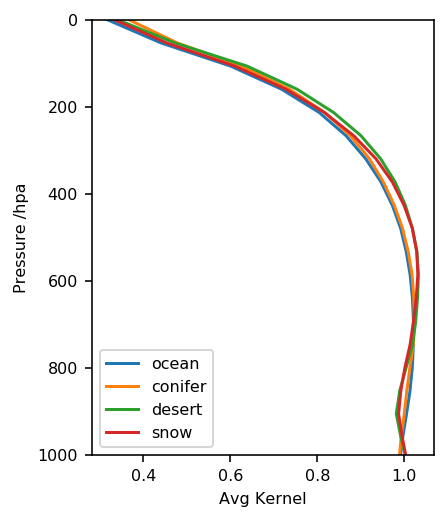

In [11]:
places=['ocean', 'conifer', 'desert', 'snow'] # picked some places
lat=[38, 53, 28, 25]                          # corresponding lon and lat
lon=[-25, -127, 21, 73]

for counter, value in enumerate(places):
    x = kernel_mean(lat[counter],lon[counter])
    y=ds['sigma_levels'].values*1013 # hPa
    plt.plot(x,y,label=value)
    plt.ylim(1000,0)
    plt.axes().set_aspect(0.001)
    plt.xlabel('Avg Kernel')
    plt.ylabel('Pressure /hpa')
    plt.legend()
    #plt.title('Averaging kernel over a grid cell');
plt.savefig('../plots/avg_kernel.png', dpi=300)